# Preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!nvidia-smi

Wed May 22 08:37:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [ ]:
%pip install bitsandbytes
%pip install datasets
%pip install peft
%pip install trl
%pip install tqdm

In [ ]:
from torch import cuda

DEVICE = 'cuda:0' if cuda.is_available() else 'cpu'
DEVICE

'cuda:0'

# Load Model

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM

def create_model_and_tokenizer(model_name):
    tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        device_map='auto',
    )
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "right"

    compute_dtype = getattr(torch, "float16")

    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=compute_dtype,
        bnb_4bit_use_double_quant=True,
    )

    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        device_map='auto',
        torch_dtype=compute_dtype,
        quantization_config=bnb_config
    )
    return model, tokenizer

In [ ]:
# Load model directly --> Takes about 3 Minutes
MODEL_NAME = "meta-llama/Llama-2-7b-hf"
model_original, tokenizer_original = create_model_and_tokenizer(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

# Load Data

In [ ]:
base_data_path = './drive/MyDrive/Studium_Kempten/Masterarbeit/Azure_Notebooks/Abgabe_Data'

data = pd.read_csv(f'{base_data_path}/topic_classification_lda_results.csv')
data

,text_original,text_preprocessed,Sentiment,source,Category,Max Topic Probability
0,I know that there are divided camps when it co...,know divide camp come ship issue part product ...,0,Amazon,3,0.991892
1,The owner responded to my Yelp comment and off...,owner respond yelp comment offer sincere apolo...,1,Yelp,4,0.982353
2,At first I didn't like the Idea of eating a su...,first idea eat sushi place middle desert makin...,2,Yelp,6,0.580407
3,Mass quantities of glop. Skip it.,mass quantity glop skip,0,Yelp,0,0.100000
4,This is my daily morning cup of coffee. I lik...,daily morning cup coffee strong coffee become ...,2,Amazon,2,0.970968
...,...,...,...,...,...,...
29995,This place has a nice selection of Shoes. The ...,place nice selection shoe customer service lac...,1,Yelp,5,0.987324
29996,vet recommended dogs love this kind better tha...,vet recommend dog love kind well one note sens...,2,Amazon,7,0.982353
29997,I first had Popchips last week at a local deli...,first popchips last week local deli miami impr...,2,Amazon,7,0.995522
29998,inexpensive good value chose principal pretty ...,inexpensive good value choose principal pretty...,1,Trip Advisor,1,0.509834


# Prepare Prompt

In [ ]:
def generate_topic_prompt(data_point):
    return f"""### Instruction:
Classify the following review into one of the categories. Each category is defined as follows:
T0: Hotel stay and accommodation - Reviews discussing room quality, amenities, and overall accommodation.
T1: Hotel service quality - Reviews focusing on the quality of service received during a hotel stay.
T2: Service and catering - Reviews in which the customer expresses his experiences regarding service and catering.
T3: General review of products and services - Reviews in which the customer shares his thoughts of experiences and activities.
T4: Product ordering and delivery - Reviews that evaluate the ordering and delivery process of services or products.
T5: Service and atmosphere - Reviews discussing the overall quality of service and atmosphere across various contexts.
T6: Food and beverages - Reviews that focus on the quality and selection of food and drinks.
T7: Taste and flavor - Reviews specifically discussing the taste or flavor of food and drinks.
T8: Service and location - Reviews discussing the combination of service quality and location benefits.
T9: Price and product quality - Reviews that focus on the pricing and overall product quality.

Here are some examples:
- "I had a fantastic stay at the Grand Hotel. The room was spacious, clean, and equipped with all the necessary amenities. The bed was incredibly comfortable, and I enjoyed the beautiful view from my balcony." Response: 0
- "The staff at the Sunrise Inn were incredibly attentive and friendly. They went out of their way to ensure we had everything we needed. The concierge service was particularly helpful in recommending local attractions." Response: 1
- "The restaurant was luxurious, the food was delicious, and there were plenty of activities for the whole family. The people there made our stay even more enjoyable with their excellent service." Response: 2
- "I recently tried out a new streaming service and was quite impressed. The user interface is intuitive, the content selection is diverse, and the streaming quality is top-notch. It's a great addition to my entertainment options." Response: 3
- "Ordering from TechGear was a breeze. The website was easy to navigate, and my new laptop arrived within two days. The packaging was secure, and the product was exactly as described." Response: 4
- "The atmosphere at Café Delight is cozy and inviting. The staff are always welcoming, and the service is prompt. It's my favorite spot to relax with a cup of coffee and a good book." Response: 5
- "The restaurant at the Mountain Lodge offers an impressive menu. The food was fresh, flavorful, and beautifully presented. I particularly enjoyed the local wine selection, which perfectly complemented the meal." Response: 6
- "I tried the new salami pizza from Pizziano, and the taste was phenomenal. The crust was perfectly crispy, the toppings were fresh, and the flavors were well-balanced. It's the best pizza I've had in a long time." Response: 7
- "The Urban Hotel is ideally located in the heart of the city, making it easy to explore nearby attractions. The service was exceptional, with staff always ready to assist. It's a perfect choice for a city break." Response: 8
- "I recently purchased a new pair of running shoes online. The price was reasonable, but the quality is bad. They are uncomfortable and have worsen my running experience significantly." Response: 9

Analyze the customer review text provided below and determine its most relevant topic based on the ten topics.

### Review:
{data_point["text_original"]}
### Response:
This customer review most likely belongs to topic number
""".strip()

In [ ]:
data['prompt'] = data.apply(generate_topic_prompt, axis=1)
data['prompt'].iloc[0]

'### Instruction:\nClassify the following review into one of the categories. Each category is defined as follows:\nT0: Hotel stay and accommodation - Reviews discussing room quality, amenities, and overall accommodation.\nT1: Hotel service quality - Reviews focusing on the quality of service received during a hotel stay.\nT2: Service and catering - Reviews in which the customer expresses his experiences regarding service and catering.\nT3: General review of products and services - Reviews in which the customer shares his thoughts of experiences and activities.\nT4: Product ordering and delivery - Reviews that evaluate the ordering and delivery process of services or products.\nT5: Service and atmosphere - Reviews discussing the overall quality of service and atmosphere across various contexts.\nT6: Food and beverages - Reviews that focus on the quality and selection of food and drinks.\nT7: Taste and flavor - Reviews specifically discussing the taste or flavor of food and drinks.\nT8: 

In [ ]:
dataset = Dataset.from_pandas(data[['prompt', 'Category']])
dataset

Dataset({
    features: ['prompt', 'Category'],
    num_rows: 30000
})

# Example Inference

In [ ]:
def predict_topic(model, tokenizer, text: str):
    inputs = tokenizer(text, return_tensors="pt").to(DEVICE)
    inputs_length = len(inputs["input_ids"][0])
    with torch.inference_mode():
        outputs = model.generate(**inputs, max_new_tokens=2, temperature=0.0001)
    return tokenizer.decode(outputs[0][inputs_length:], skip_special_tokens=True).strip()

In [ ]:
example = dataset[11]
print(example['prompt'])
print('-'*20)
print(example['Category'])

### Instruction:
Classify the following review into one of the categories. Each category is defined as follows:
T0: Hotel stay and accommodation - Reviews discussing room quality, amenities, and overall accommodation.
T1: Hotel service quality - Reviews focusing on the quality of service received during a hotel stay.
T2: Service and catering - Reviews in which the customer expresses his experiences regarding service and catering.
T3: General review of products and services - Reviews in which the customer shares his thoughts of experiences and activities.
T4: Product ordering and delivery - Reviews that evaluate the ordering and delivery process of services or products.
T5: Service and atmosphere - Reviews discussing the overall quality of service and atmosphere across various contexts.
T6: Food and beverages - Reviews that focus on the quality and selection of food and drinks.
T7: Taste and flavor - Reviews specifically discussing the taste or flavor of food and drinks.
T8: Service and

In [ ]:
%%time
sentiment = predict_topic(model_original, tokenizer_original, example['prompt'])
sentiment

CPU times: user 2 s, sys: 483 ms, total: 2.48 s
Wall time: 3.84 s


'2'

# Use Llama 2 for Topic Classification

In [ ]:
 %%time

from tqdm import tqdm
# Evaluation of 30.000 test data took about 9h. The operation was executed in multiple runs.

DATA_LEN = 30000
STEP_SIZE = 100
csv_file_path = f'{base_data_path}/llm_topic_modeling_predictions.csv'

accepted_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
accepted_int_labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

# Check how many Batches are already completed
try:
    existing_df = pd.read_csv(csv_file_path)
    completed_batches = len(existing_df) // STEP_SIZE
    print(f"{completed_batches} Batches bereits abgeschlossen. Setze fort...")
except FileNotFoundError:
    completed_batches = 0
    # Initialize the DataFrame
    df = pd.DataFrame(columns=['prompt', 'y_true', 'y_pred', 'source', 'text_original'])
    # Save empty CSV-file including the headers
    df.to_csv(csv_file_path, index=False)
    print(f"Creating new CSV file at {csv_file_path}...")

# Use tqdm and batch processing to visualize the progress and save interim results
for start_idx in tqdm(range(completed_batches * STEP_SIZE, DATA_LEN, STEP_SIZE), desc="Processing batches"):
    end_idx = min(start_idx + STEP_SIZE, DATA_LEN)

    prompts_batch = dataset['prompt'][start_idx:end_idx]
    y_true_batch = dataset['Category'][start_idx:end_idx]

    y_pred_batch = [predict_topic(model_original, tokenizer_original, prompt) for prompt in prompts_batch]
    y_pred_filled_batch = [9 if item not in accepted_labels else int(item) for item in y_pred_batch]

    if len(prompts_batch) == len(y_true_batch) == len(y_pred_filled_batch) == len(data['source'][start_idx:end_idx]) == len(data['text_original'][start_idx:end_idx]):
        df_batch = pd.DataFrame({
            'prompt': prompts_batch,
            'y_true': y_true_batch,
            'y_pred': y_pred_filled_batch,
            'source': data['source'][start_idx:end_idx],
            'text_original': data['text_original'][start_idx:end_idx]
        })

        # Append interim results to the CSV-file
        df_batch.to_csv(csv_file_path, mode='a', header=False, index=False)

        print(f"Batch {start_idx // STEP_SIZE + 1} von {DATA_LEN // STEP_SIZE} abgeschlossen.")
    else:
        print(f"Error in Batch {start_idx // STEP_SIZE + 1}: Unequal length of lists. Skipping this Batch.")
        print('Lengths: ', len(prompts_batch), len(y_true_batch), len(y_pred_filled_batch), len(data['source'][start_idx:end_idx]), len(data['text_original'][start_idx:end_idx]))

print(f"Evaluation abgeschlossen. CSV-Datei wurde unter {csv_file_path} gespeichert.")

188 Batches bereits abgeschlossen. Setze fort...


Processing batches:   1%|          | 1/112 [01:38<3:02:04, 98.42s/it]

Batch 189 von 300 abgeschlossen.


Processing batches:   2%|▏         | 2/112 [03:15<2:58:55, 97.60s/it]

Batch 190 von 300 abgeschlossen.


Processing batches:   3%|▎         | 3/112 [04:50<2:55:25, 96.56s/it]

Batch 191 von 300 abgeschlossen.


Processing batches:   4%|▎         | 4/112 [06:28<2:54:37, 97.01s/it]

Batch 192 von 300 abgeschlossen.


Processing batches:   4%|▍         | 5/112 [08:04<2:52:16, 96.60s/it]

Batch 193 von 300 abgeschlossen.


Processing batches:   5%|▌         | 6/112 [09:40<2:50:20, 96.42s/it]

Batch 194 von 300 abgeschlossen.


Processing batches:   6%|▋         | 7/112 [11:16<2:48:20, 96.20s/it]

Batch 195 von 300 abgeschlossen.


Processing batches:   7%|▋         | 8/112 [12:51<2:46:30, 96.06s/it]

Batch 196 von 300 abgeschlossen.


Processing batches:   8%|▊         | 9/112 [14:28<2:45:10, 96.22s/it]

Batch 197 von 300 abgeschlossen.


Processing batches:   9%|▉         | 10/112 [16:03<2:43:09, 95.97s/it]

Batch 198 von 300 abgeschlossen.


Processing batches:  10%|▉         | 11/112 [17:41<2:42:18, 96.42s/it]

Batch 199 von 300 abgeschlossen.


Processing batches:  11%|█         | 12/112 [19:18<2:40:54, 96.55s/it]

Batch 200 von 300 abgeschlossen.


Processing batches:  12%|█▏        | 13/112 [20:53<2:38:47, 96.23s/it]

Batch 201 von 300 abgeschlossen.


Processing batches:  12%|█▎        | 14/112 [22:28<2:36:43, 95.95s/it]

Batch 202 von 300 abgeschlossen.


Processing batches:  13%|█▎        | 15/112 [24:06<2:35:44, 96.33s/it]

Batch 203 von 300 abgeschlossen.


Processing batches:  14%|█▍        | 16/112 [25:44<2:35:12, 97.01s/it]

Batch 204 von 300 abgeschlossen.


Processing batches:  15%|█▌        | 17/112 [27:19<2:32:33, 96.36s/it]

Batch 205 von 300 abgeschlossen.


Processing batches:  16%|█▌        | 18/112 [28:55<2:30:37, 96.14s/it]

Batch 206 von 300 abgeschlossen.


Processing batches:  17%|█▋        | 19/112 [30:31<2:29:03, 96.17s/it]

Batch 207 von 300 abgeschlossen.


Processing batches:  18%|█▊        | 20/112 [32:08<2:28:00, 96.52s/it]

Batch 208 von 300 abgeschlossen.


Processing batches:  19%|█▉        | 21/112 [33:45<2:26:27, 96.57s/it]

Batch 209 von 300 abgeschlossen.


Processing batches:  20%|█▉        | 22/112 [35:22<2:24:57, 96.63s/it]

Batch 210 von 300 abgeschlossen.


Processing batches:  21%|██        | 23/112 [36:58<2:23:03, 96.44s/it]

Batch 211 von 300 abgeschlossen.


Processing batches:  21%|██▏       | 24/112 [38:34<2:21:21, 96.38s/it]

Batch 212 von 300 abgeschlossen.


Processing batches:  22%|██▏       | 25/112 [40:11<2:20:00, 96.56s/it]

Batch 213 von 300 abgeschlossen.


Processing batches:  23%|██▎       | 26/112 [41:46<2:17:37, 96.02s/it]

Batch 214 von 300 abgeschlossen.


Processing batches:  24%|██▍       | 27/112 [43:21<2:15:40, 95.77s/it]

Batch 215 von 300 abgeschlossen.


Processing batches:  25%|██▌       | 28/112 [44:58<2:14:47, 96.28s/it]

Batch 216 von 300 abgeschlossen.


Processing batches:  26%|██▌       | 29/112 [46:35<2:13:14, 96.32s/it]

Batch 217 von 300 abgeschlossen.


Processing batches:  27%|██▋       | 30/112 [48:10<2:10:59, 95.85s/it]

Batch 218 von 300 abgeschlossen.


Processing batches:  28%|██▊       | 31/112 [49:44<2:08:48, 95.41s/it]

Batch 219 von 300 abgeschlossen.


Processing batches:  29%|██▊       | 32/112 [51:21<2:07:47, 95.84s/it]

Batch 220 von 300 abgeschlossen.


Processing batches:  29%|██▉       | 33/112 [52:56<2:05:58, 95.67s/it]

Batch 221 von 300 abgeschlossen.


Processing batches:  30%|███       | 34/112 [54:32<2:04:20, 95.64s/it]

Batch 222 von 300 abgeschlossen.


Processing batches:  31%|███▏      | 35/112 [56:08<2:03:05, 95.91s/it]

Batch 223 von 300 abgeschlossen.


Processing batches:  32%|███▏      | 36/112 [57:44<2:01:20, 95.80s/it]

Batch 224 von 300 abgeschlossen.


Processing batches:  33%|███▎      | 37/112 [59:19<1:59:34, 95.66s/it]

Batch 225 von 300 abgeschlossen.


Processing batches:  34%|███▍      | 38/112 [1:00:57<1:58:46, 96.31s/it]

Batch 226 von 300 abgeschlossen.


Processing batches:  35%|███▍      | 39/112 [1:02:32<1:56:36, 95.85s/it]

Batch 227 von 300 abgeschlossen.


Processing batches:  36%|███▌      | 40/112 [1:04:07<1:54:40, 95.57s/it]

Batch 228 von 300 abgeschlossen.


Processing batches:  37%|███▋      | 41/112 [1:05:43<1:53:24, 95.84s/it]

Batch 229 von 300 abgeschlossen.


Processing batches:  38%|███▊      | 42/112 [1:07:21<1:52:23, 96.34s/it]

Batch 230 von 300 abgeschlossen.


Processing batches:  38%|███▊      | 43/112 [1:08:55<1:49:58, 95.64s/it]

Batch 231 von 300 abgeschlossen.


Processing batches:  39%|███▉      | 44/112 [1:10:32<1:49:01, 96.19s/it]

Batch 232 von 300 abgeschlossen.


Processing batches:  40%|████      | 45/112 [1:12:09<1:47:40, 96.42s/it]

Batch 233 von 300 abgeschlossen.


Processing batches:  41%|████      | 46/112 [1:13:46<1:46:15, 96.60s/it]

Batch 234 von 300 abgeschlossen.


Processing batches:  42%|████▏     | 47/112 [1:15:21<1:44:07, 96.11s/it]

Batch 235 von 300 abgeschlossen.


Processing batches:  43%|████▎     | 48/112 [1:16:56<1:42:10, 95.79s/it]

Batch 236 von 300 abgeschlossen.


Processing batches:  44%|████▍     | 49/112 [1:18:32<1:40:29, 95.71s/it]

Batch 237 von 300 abgeschlossen.


Processing batches:  45%|████▍     | 50/112 [1:20:07<1:38:49, 95.64s/it]

Batch 238 von 300 abgeschlossen.


Processing batches:  46%|████▌     | 51/112 [1:21:44<1:37:35, 95.99s/it]

Batch 239 von 300 abgeschlossen.


Processing batches:  46%|████▋     | 52/112 [1:23:18<1:35:22, 95.38s/it]

Batch 240 von 300 abgeschlossen.


Processing batches:  47%|████▋     | 53/112 [1:24:53<1:33:39, 95.24s/it]

Batch 241 von 300 abgeschlossen.


Processing batches:  48%|████▊     | 54/112 [1:26:29<1:32:22, 95.57s/it]

Batch 242 von 300 abgeschlossen.


Processing batches:  49%|████▉     | 55/112 [1:28:06<1:31:13, 96.03s/it]

Batch 243 von 300 abgeschlossen.


Processing batches:  50%|█████     | 56/112 [1:29:41<1:29:17, 95.67s/it]

Batch 244 von 300 abgeschlossen.


Processing batches:  51%|█████     | 57/112 [1:31:19<1:28:12, 96.23s/it]

Batch 245 von 300 abgeschlossen.


Processing batches:  52%|█████▏    | 58/112 [1:32:56<1:26:54, 96.57s/it]

Batch 246 von 300 abgeschlossen.


Processing batches:  53%|█████▎    | 59/112 [1:34:32<1:25:16, 96.54s/it]

Batch 247 von 300 abgeschlossen.


Processing batches:  54%|█████▎    | 60/112 [1:36:08<1:23:32, 96.40s/it]

Batch 248 von 300 abgeschlossen.


Processing batches:  54%|█████▍    | 61/112 [1:37:45<1:21:56, 96.40s/it]

Batch 249 von 300 abgeschlossen.


Processing batches:  55%|█████▌    | 62/112 [1:39:21<1:20:16, 96.33s/it]

Batch 250 von 300 abgeschlossen.


Processing batches:  56%|█████▋    | 63/112 [1:40:59<1:19:03, 96.81s/it]

Batch 251 von 300 abgeschlossen.


Processing batches:  57%|█████▋    | 64/112 [1:42:36<1:17:31, 96.92s/it]

Batch 252 von 300 abgeschlossen.


Processing batches:  58%|█████▊    | 65/112 [1:44:11<1:15:31, 96.41s/it]

Batch 253 von 300 abgeschlossen.


Processing batches:  59%|█████▉    | 66/112 [1:45:46<1:13:28, 95.85s/it]

Batch 254 von 300 abgeschlossen.


Processing batches:  60%|█████▉    | 67/112 [1:47:21<1:11:38, 95.53s/it]

Batch 255 von 300 abgeschlossen.


This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (4096). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
Processing batches:  61%|██████    | 68/112 [1:48:57<1:10:20, 95.92s/it]

Batch 256 von 300 abgeschlossen.


Processing batches:  62%|██████▏   | 69/112 [1:50:33<1:08:44, 95.92s/it]

Batch 257 von 300 abgeschlossen.


Processing batches:  62%|██████▎   | 70/112 [1:52:11<1:07:30, 96.44s/it]

Batch 258 von 300 abgeschlossen.


Processing batches:  63%|██████▎   | 71/112 [1:53:46<1:05:31, 95.88s/it]

Batch 259 von 300 abgeschlossen.


Processing batches:  64%|██████▍   | 72/112 [1:55:21<1:03:47, 95.69s/it]

Batch 260 von 300 abgeschlossen.


Processing batches:  65%|██████▌   | 73/112 [1:56:58<1:02:32, 96.21s/it]

Batch 261 von 300 abgeschlossen.


Processing batches:  66%|██████▌   | 74/112 [1:58:32<1:00:27, 95.45s/it]

Batch 262 von 300 abgeschlossen.


Processing batches:  67%|██████▋   | 75/112 [2:00:08<59:03, 95.76s/it]  

Batch 263 von 300 abgeschlossen.


Processing batches:  68%|██████▊   | 76/112 [2:01:45<57:37, 96.04s/it]

Batch 264 von 300 abgeschlossen.


Processing batches:  69%|██████▉   | 77/112 [2:03:22<56:12, 96.37s/it]

Batch 265 von 300 abgeschlossen.


Processing batches:  70%|██████▉   | 78/112 [2:04:59<54:35, 96.35s/it]

Batch 266 von 300 abgeschlossen.


Processing batches:  71%|███████   | 79/112 [2:06:35<52:56, 96.27s/it]

Batch 267 von 300 abgeschlossen.


Processing batches:  71%|███████▏  | 80/112 [2:08:11<51:19, 96.24s/it]

Batch 268 von 300 abgeschlossen.


Processing batches:  72%|███████▏  | 81/112 [2:09:45<49:28, 95.75s/it]

Batch 269 von 300 abgeschlossen.


Processing batches:  73%|███████▎  | 82/112 [2:11:20<47:45, 95.50s/it]

Batch 270 von 300 abgeschlossen.


Processing batches:  74%|███████▍  | 83/112 [2:12:56<46:09, 95.51s/it]

Batch 271 von 300 abgeschlossen.


Processing batches:  75%|███████▌  | 84/112 [2:14:34<44:56, 96.29s/it]

Batch 272 von 300 abgeschlossen.


Processing batches:  76%|███████▌  | 85/112 [2:16:11<43:23, 96.42s/it]

Batch 273 von 300 abgeschlossen.


Processing batches:  77%|███████▋  | 86/112 [2:17:45<41:30, 95.79s/it]

Batch 274 von 300 abgeschlossen.


Processing batches:  78%|███████▊  | 87/112 [2:19:22<40:00, 96.04s/it]

Batch 275 von 300 abgeschlossen.


Processing batches:  79%|███████▊  | 88/112 [2:20:58<38:25, 96.08s/it]

Batch 276 von 300 abgeschlossen.


Processing batches:  79%|███████▉  | 89/112 [2:22:34<36:48, 96.03s/it]

Batch 277 von 300 abgeschlossen.


Processing batches:  80%|████████  | 90/112 [2:24:11<35:20, 96.38s/it]

Batch 278 von 300 abgeschlossen.


Processing batches:  81%|████████▏ | 91/112 [2:25:45<33:32, 95.81s/it]

Batch 279 von 300 abgeschlossen.


Processing batches:  82%|████████▏ | 92/112 [2:27:22<32:03, 96.18s/it]

Batch 280 von 300 abgeschlossen.


Processing batches:  83%|████████▎ | 93/112 [2:28:59<30:28, 96.22s/it]

Batch 281 von 300 abgeschlossen.


Processing batches:  84%|████████▍ | 94/112 [2:30:34<28:45, 95.87s/it]

Batch 282 von 300 abgeschlossen.


Processing batches:  85%|████████▍ | 95/112 [2:32:09<27:07, 95.76s/it]

Batch 283 von 300 abgeschlossen.


Processing batches:  86%|████████▌ | 96/112 [2:33:46<25:36, 96.05s/it]

Batch 284 von 300 abgeschlossen.


Processing batches:  87%|████████▋ | 97/112 [2:35:23<24:03, 96.25s/it]

Batch 285 von 300 abgeschlossen.


Processing batches:  88%|████████▊ | 98/112 [2:36:57<22:20, 95.75s/it]

Batch 286 von 300 abgeschlossen.


Processing batches:  88%|████████▊ | 99/112 [2:38:32<20:39, 95.33s/it]

Batch 287 von 300 abgeschlossen.


Processing batches:  89%|████████▉ | 100/112 [2:40:06<18:59, 94.98s/it]

Batch 288 von 300 abgeschlossen.


Processing batches:  90%|█████████ | 101/112 [2:41:42<17:26, 95.17s/it]

Batch 289 von 300 abgeschlossen.


Processing batches:  91%|█████████ | 102/112 [2:43:16<15:50, 95.04s/it]

Batch 290 von 300 abgeschlossen.


Processing batches:  92%|█████████▏| 103/112 [2:44:52<14:16, 95.19s/it]

Batch 291 von 300 abgeschlossen.


Processing batches:  93%|█████████▎| 104/112 [2:46:28<12:43, 95.49s/it]

Batch 292 von 300 abgeschlossen.


Processing batches:  94%|█████████▍| 105/112 [2:48:05<11:10, 95.81s/it]

Batch 293 von 300 abgeschlossen.


Processing batches:  95%|█████████▍| 106/112 [2:49:40<09:33, 95.64s/it]

Batch 294 von 300 abgeschlossen.


Processing batches:  96%|█████████▌| 107/112 [2:51:16<07:58, 95.68s/it]

Batch 295 von 300 abgeschlossen.


Processing batches:  96%|█████████▋| 108/112 [2:52:51<06:21, 95.47s/it]

Batch 296 von 300 abgeschlossen.


Processing batches:  97%|█████████▋| 109/112 [2:54:25<04:45, 95.20s/it]

Batch 297 von 300 abgeschlossen.


Processing batches:  98%|█████████▊| 110/112 [2:56:00<03:09, 95.00s/it]

Batch 298 von 300 abgeschlossen.


Processing batches:  99%|█████████▉| 111/112 [2:57:35<01:35, 95.15s/it]

Batch 299 von 300 abgeschlossen.


Processing batches: 100%|██████████| 112/112 [2:59:08<00:00, 95.97s/it]

Batch 300 von 300 abgeschlossen.
Evaluation abgeschlossen. CSV-Datei wurde unter ./drive/MyDrive/Studium_Kempten/Masterarbeit/Azure_Notebooks/data_for_export/llm_topic_modeling_predictions.csv gespeichert.
CPU times: user 2h 21min 42s, sys: 35min 38s, total: 2h 57min 20s
Wall time: 2h 59min 10s


In [ ]:
import pandas as pd
eval_df = pd.read_csv(f'{base_data_path}/llm_topic_modeling_predictions.csv')
eval_df

,prompt,y_true,y_pred,source,text_original
0,### Instruction:\nClassify the following revie...,3,3,Amazon,I know that there are divided camps when it co...
1,### Instruction:\nClassify the following revie...,4,0,Yelp,The owner responded to my Yelp comment and off...
2,### Instruction:\nClassify the following revie...,6,2,Yelp,At first I didn't like the Idea of eating a su...
3,### Instruction:\nClassify the following revie...,0,9,Yelp,Mass quantities of glop. Skip it.
4,### Instruction:\nClassify the following revie...,2,5,Amazon,This is my daily morning cup of coffee. I lik...
...,...,...,...,...,...
29995,### Instruction:\nClassify the following revie...,5,0,Yelp,This place has a nice selection of Shoes. The ...
29996,### Instruction:\nClassify the following revie...,7,2,Amazon,vet recommended dogs love this kind better tha...
29997,### Instruction:\nClassify the following revie...,7,2,Amazon,I first had Popchips last week at a local deli...
29998,### Instruction:\nClassify the following revie...,1,0,Trip Advisor,inexpensive good value chose principal pretty ...


# Evaluation of Llama 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

In [ ]:
import seaborn as sns
sns.set()

def thousand_separator(x, pos):
    return '{:,.0f}'.format(x).replace(',', '.')

In [ ]:
import matplotlib.pyplot as plt
def display_confusion_matrix(confusion_matrix):
    plt.figure()
    sns.heatmap(confusion_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
def compute_metrics(labels, predictions):
    cm = confusion_matrix(labels, predictions)
    display_confusion_matrix(cm)
    accuracy = accuracy_score(labels, predictions)
    report = classification_report(labels, predictions, output_dict=True)
    print(f"Accuracy: {accuracy}")

    unique_labels = set(labels)  # Get unique labels
    for label in unique_labels:
        label_indices = [i for i in range(len(labels))
                         if labels[i] == label]
        label_y_true = [labels[i] for i in label_indices]
        label_y_pred = [predictions[i] for i in label_indices]
        accuracy_label = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy_label:.3f}')

    print("Classification Report:")
    print(report)
    return {
        'accuracy': accuracy,
        'precision_weighted': report['weighted avg']['precision'],
        'recall_weighted': report['weighted avg']['recall'],
        'f1_weighted': report['weighted avg']['f1-score'],
        'precision_macro': report['macro avg']['precision'],
        'recall_macro': report['macro avg']['recall'],
        'f1_macro': report['macro avg']['f1-score'],
    }

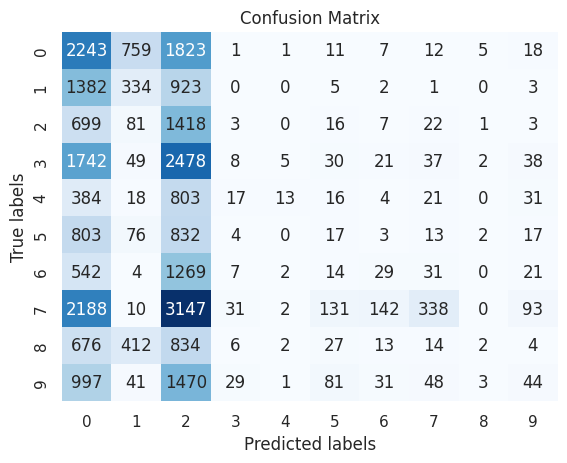

Accuracy: 0.1482
Accuracy for label 0: 0.460
Accuracy for label 1: 0.126
Accuracy for label 2: 0.630
Accuracy for label 3: 0.002
Accuracy for label 4: 0.010
Accuracy for label 5: 0.010
Accuracy for label 6: 0.015
Accuracy for label 7: 0.056
Accuracy for label 8: 0.001
Accuracy for label 9: 0.016
Classification Report:
{'0': {'precision': 0.192433081674674, 'recall': 0.4596311475409836, 'f1-score': 0.2712868892114175, 'support': 4880}, '1': {'precision': 0.18721973094170405, 'recall': 0.12603773584905661, 'f1-score': 0.1506540369869193, 'support': 2650}, '2': {'precision': 0.09455224378208975, 'recall': 0.6302222222222222, 'f1-score': 0.16443439438742968, 'support': 2250}, '3': {'precision': 0.07547169811320754, 'recall': 0.0018140589569160999, 'f1-score': 0.0035429583702391502, 'support': 4410}, '4': {'precision': 0.5, 'recall': 0.009946442234123947, 'f1-score': 0.01950487621905476, 'support': 1307}, '5': {'precision': 0.04885057471264368, 'recall': 0.009620826259196379, 'f1-score': 0.

{'accuracy': 0.1482,
 'precision_weighted': 0.24909975269715548,
 'recall_weighted': 0.1482,
 'f1_weighted': 0.09729696254928359,
 'precision_macro': 0.21350171992173111,
 'recall_macro': 0.13249924640055333,
 'f1_macro': 0.07854220323652111}

In [ ]:
compute_metrics(eval_df['y_true'], eval_df['y_pred'])

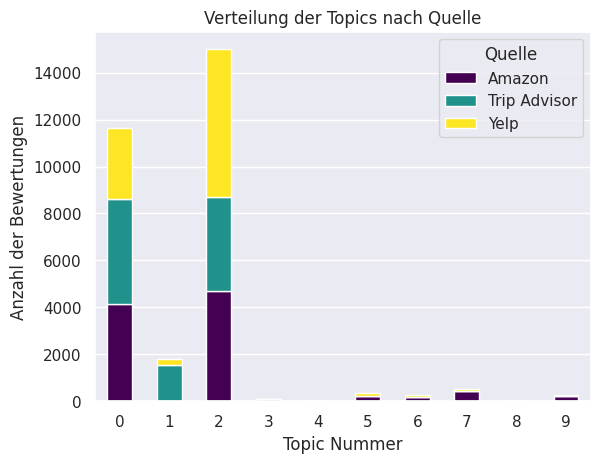

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set()
topic_source_distribution = eval_df.groupby(['y_pred', 'source']).size().unstack(fill_value=0)
topic_source_distribution.plot(kind='bar', stacked=True, colormap='viridis')

plt.title('Verteilung der Topics nach Quelle')
plt.xlabel('Topic Nummer')
plt.ylabel('Anzahl der Bewertungen')
plt.legend(title='Quelle')

plt.grid(axis='x')

plt.xticks(rotation=0)
plt.show()

In [ ]:
def visualize_weighted_and_macro(data):
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x='Metric', y='Value', hue='Model', palette='viridis', data=data)
    plt.title('Weighted und Macro Metriken')
    plt.ylabel('Score')
    plt.xlabel('Metrik')
    plt.ylim(0, 1)
    plt.legend(title='Modell')

    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.3f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()-0.03),
                    ha = 'center', va = 'center',
                    color='white',
                    xytext = (0,0),
                    textcoords = 'offset points')
    plt.xticks(rotation=12)
    plt.show()

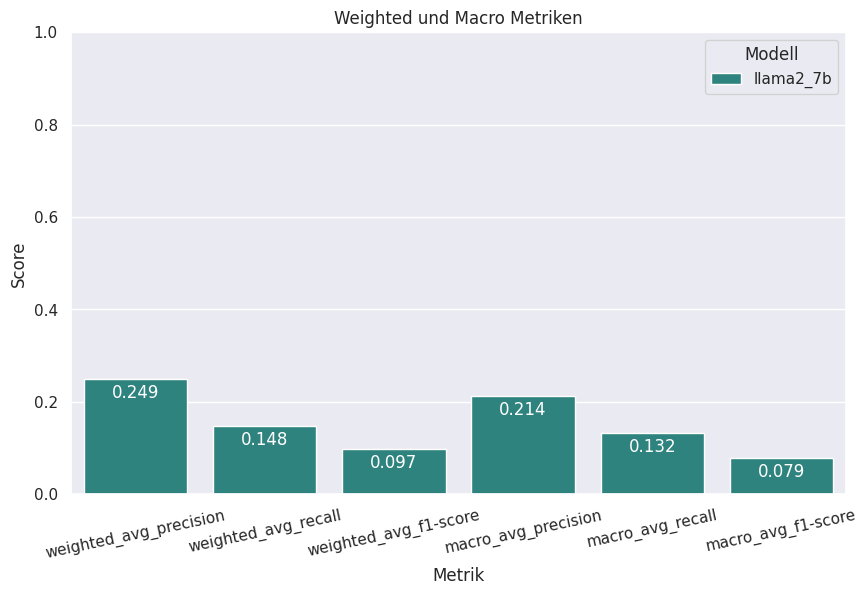

In [ ]:
eval_results = {
  'Model': 'llama2_7b',
  'accuracy': 0.1482,
  'macro_avg_precision': 0.21350171992173111,
  'macro_avg_recall': 0.13249924640055333,
  'macro_avg_f1-score': 0.07854220323652111,
  'weighted_avg_precision': 0.24909975269715548,
  'weighted_avg_recall': 0.1482,
  'weighted_avg_f1-score': 0.09729696254928359
}

results_df = pd.DataFrame([eval_results])

df_eval_results = results_df.melt(id_vars='Model', value_vars=['weighted_avg_precision', 'weighted_avg_recall', 'weighted_avg_f1-score', 'macro_avg_precision', 'macro_avg_recall', 'macro_avg_f1-score'], var_name='Metric', value_name='Value')

visualize_weighted_and_macro(df_eval_results)